# Games and Argumentation: Time for a Family Reunion！

This notebook aims to demonstrate the paper "Game and Argumentation: Time for a Family Reunion" accepted by XLoKR 2023

The move graph above defines a game $G = (V, E)$ with positions $V$ and moves $E$. Based on the $win(X) ← move(X, Y ), ¬ win(Y ).$, we can solve this game by
1) Identifying sink nodes, or lost positions which did not have outgoing moves
2) Then we iteratively run the following rules:
- Position $x$ is won (green) if $∃ y$ s.t. $move(x,y)$ and position $y$ is already lost (red)
- Position $x$ is lost (red) if $∀ y$ if $move(x,y)$ then position $y$ is already won (green)

## Pre-Settings

Package import

In [1]:
from statelog_functions import *

Mode selection

In [2]:
mode = "game"
# mode = "argumentation"

## Move Graph

To help future reasoning, here we turn the graphs into facts

In [3]:
%%file files/move_graph.dlv

#maxint = 100.

m(a,b).
m(a,c).
m(k,l).
m(c,d).
m(c,e).
m(l,e).
m(l,m).
m(d,e).
m(e,d).
m(e,m).
m(m,e).
m(d,f).
m(d,g).
m(g,d).
m(e,h).
m(m,n).
m(n,m).

Overwriting files/move_graph.dlv


Extract Move Graph Structure

In [4]:
edge_df=read_edges_from_file("files/move_graph.dlv")

# Solve Game

### Game Solve Script (DLV)

In [5]:
%%file files/game_solve.dlv

% Positions
p(X) :- m(X,_).
p(X) :- m(_,X).

% win_u: underestimate of WON positions
u(S1, X) :-
    m(X,Y),
	not o(S,Y),
	nxt(S,S1). % S1 = S + 1

%: win_o: overestimate of WON positions
o(S, X) :-
	m(X,Y),
	not u(S,Y),
	nxt(S,_).
% GREEN (won) positions 
g(X) :-
	fg(_,X).  

% YELLOW (drawn) positions
y(X) :-
	p(X),
	not g(X),
	not r(X).

% RED (lost) positions
r(X) :- fr(_,X).

% State generation for AFP 
nxt(0,1).
nxt(S,S1) :-			% S1 (=S+1) is a state,
	nxt(_,S),		% ... if S is a state
	chg(S),			% ... which changes
	S1=S+1.    

% change(S)
chg(0).				% in 0 there is change
chg(S) :-			% in S there is change
	fg(S,_).		% ... if there is some FirstGreen

% final(S)
fin(S) :-			% S is the final state
	nxt(_,S),     
	not chg(S).		% ... if there is no change in S

% FirstGreen(State, Position)
fg(S1,X) :- 		       % position X is first green in S1 (=S+1)
	nxt(S,S1),
	u(S1,X),               % ... if win_u(S1,X)
	not u(S,X).            % ... but not win_u(S,X)

% FirstRed(State, Position)
fr(0,X) :-                     % X is first red in 0
	p(X),                  % ... if X is a position
	not o(0,X).            % ... that isn't even in the first overestimate (at 0)

fr(S1,X) :-                    % X is first red in S1 (=S+1)
	nxt(S,S1),
	o(S,X),                % ... if X was in the previous overestimate win_o(S,X)
	not o(S1,X),           % ... but isn't now in win_o(S1,X)
	not fin(S1).           % but exclude final state (we don't compute o(Final,...) )
%	not u(S1,X).           




% node(Color, State, Position)
node(g,S,X) :- fg(S,X).
node(r,S,X) :- fr(S,X).
node(y,S,X) :- y(X),fin(S).


outn(gr,S1,X,Y) :-
	m(X,Y), nxt(S,S1),
	g(X), fr(S,Y).		% GREEN --(s+1)--> FIRST-RED(s) 
outn(rg,S,X,Y) :- m(X,Y), r(X), fg(S,Y).

out(gg,X,Y) :- m(X,Y), g(X), g(Y).
out(gy,X,Y) :- m(X,Y), g(X), y(Y).
out(yg,X,Y) :- m(X,Y), y(X), g(Y).
% out(x,X,Y) :- m(X,Y), r(X), r(Y).
% out(x,X,Y) :- m(X,Y), r(X), y(Y).
% out(x,X,Y) :- m(X,Y), y(X), r(Y).
out(yy,X,Y) :- m(X,Y), y(X), y(Y).

Overwriting files/game_solve.dlv


In [6]:
!dlv files/move_graph.dlv files/game_solve.dlv -filter="node"

DLV [build BEN/Dec 17 2012   gcc 4.6.1]

{node(r,0,b), node(r,0,f), node(r,0,h), node(g,1,a), node(g,1,d), node(g,1,e), node(r,1,c), node(r,1,g), node(y,2,k), node(y,2,l), node(y,2,m), node(y,2,n)}


### Process DLV Output

For a clear demonstration, we parse the output of DLV into a DataFrame

In [7]:
cmd = "dlv files/move_graph.dlv files/game_solve.dlv -filter='node',"
output = run_command(cmd)
state_df = to_dataframe(output)
redefined_state_df=redefine_states(state_df)

## Color the Graph

In [8]:
create_colored_graph(edge_df, redefined_state_df, mode, directory_path='output')
generate_png_from_dot(directory='output')

## Animation

IntSlider(value=0, description='Slide:', max=5)

Output()

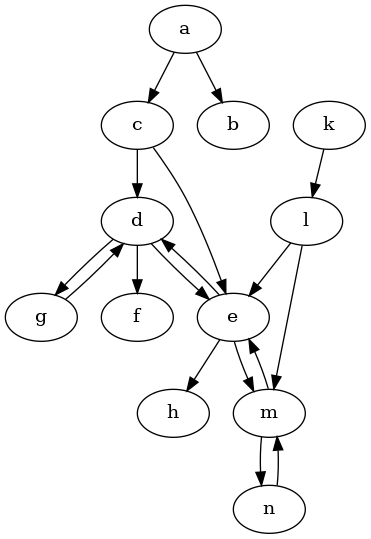

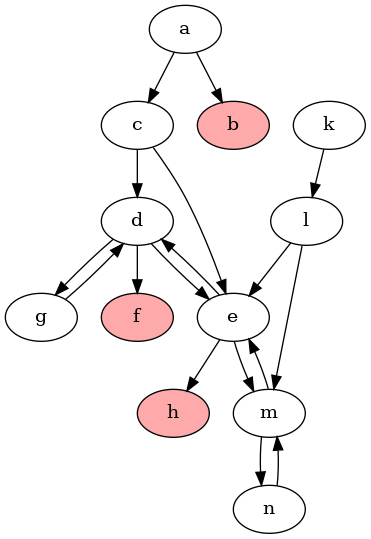

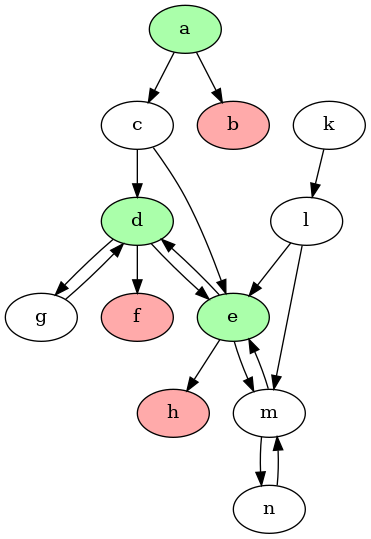

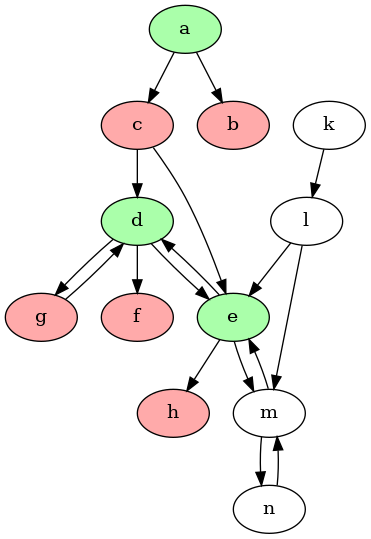

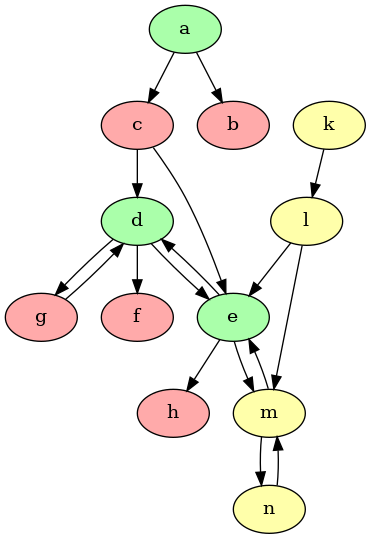

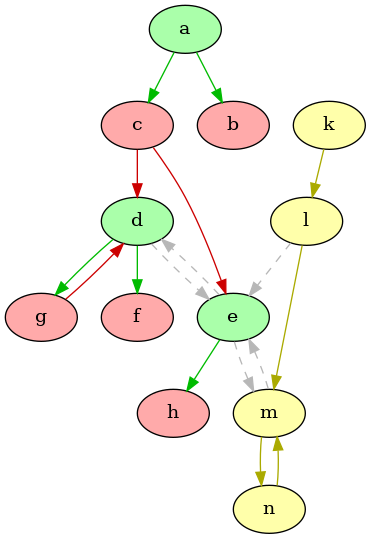

In [9]:
display_image_slider(directory='output', static=True)